<a href="https://colab.research.google.com/github/esther-pui/WOA7015-Assignment-3/blob/main/WOA7015_A3_Group.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Main Objective:**
build a **2-layer MLP** (a basic neural network) using **PyTorch** to **classify fetuses** based on a given dataset and **achieve a testing accuracy of up to 65%** by **finding the best settings** (hyperparameters)

(!remove later)

# **Step 1: Data prep (2%)**
Input (16 dimensions) -> fully connected layer (10 hidden units) -> nonlinearity (ReLU)
-> fully connected (5 hidden units) -> softmax


1. Split data into 2 dataset (training, validation)
2. Load 2 dataset (training shuffle=True)
3. Set Batch Size in both DataLoader instance

*scaling only do it on training data to prevent data leakage

(!remove later)



In [20]:
from google.colab import drive # remove later
drive.mount('/content/drive') # remove later

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# train_file_path = '/Fetus_trainingdata.csv'
# remove later
train_file_path = '/content/drive/MyDrive/UM Master 2025/SEM 1 (2025 Oct)/WOA7015 ADVANCED MACHINE LEARNING (OCC4)/Assignment 3/Fetus_trainingdata.csv'

try:
  data = pd.read_csv(train_file_path)
  print('\nDrive load successfully!')

except FileNotFoundError:
  print("File not found, check your path on google drive.")
  exit()

# first column = outcome
x_features = data.iloc[:, 1:].copy()

# second to last column are the features
y_class = data.iloc[:, 0]

# ===== 1(a) Instantiate two Datasets (2%) =====

# convert into numerical code for CrossEntropyLoss
y_numeric = y_class.astype('category').cat.codes.values
num_classes = len(y_class.unique())

# one-hot encoding of categorical variables
x_features = pd.get_dummies(x_features, columns=['Ethnics'], prefix='Ethnics')
# final input dimension for mlp

input_dimension = x_features.shape[1]

# split data: training size 80%, testing size 20%
x_train_df, x_test_df, y_train_np, y_test_np = train_test_split(
    x_features,
    y_numeric,
    test_size=0.2,
    random_state=42, # ensure reproducible results
    stratify=y_numeric # make sure proportion of classes is the same
)

# scaling
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_df)
x_test_scaled = scaler.transform(x_test_df)

# datasets and dataloaders
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.long)

# instantiate 2 datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# instantiate 2 dataloaders
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True) #randomly reorder
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Drive load successfully!


# **Step 2: Building the 2-Layer MLP (2%)**
define structure of neural network using Python class (torch.nn.Module)
## Structure

Input (16 dimensions) -> fully connected layer (10 hidden units) -> nonlinearity (ReLU) -> fully connected (5 hidden units) -> softmax


1. Input Layer: Takes 16 features (16 dimensions)
2. Hidden Layer 1: fully connected layer with 10 hidden units
3. Activation: Apply ReLU non-linearity. Allows network learn complex patterns
4. Hidden Layer 2:  Fully connected layer with 5 hidden units.
5. Output Layer: Final layer have an output dimension equal to the number of classes in your fetus dataset

## Methods

*   __ init __ ( define the layers, e.g., torch.nn.Linear, torch.nn.ReLU)
*   forward method (define how data flows through these layers)

(!remove later)

In [21]:
# ===== 1(b) Instantiate your MLP class with init and forward methods (2%) =====

# how many neurons each hidden layer has
hidden_size1 = 10
hidden_size2 = 5

class MLP(nn.Module):

  # archi: input -> linear(10) -> ReLU -> linear(5) -> ReLU -> logits(2)
  def __init__(self, input_dim, h1_units, h2_units, output_dim):
    super(MLP, self).__init__()

    # fully connected (Linear) -> ReLU
    self.layer1 = nn.Sequential(
        nn.Linear(input_dim, h1_units),
        nn.ReLU()
    )

    # fully connected (Linear) -> ReLU
    self.layer2 = nn.Sequential(
        nn.Linear(h1_units, h2_units),
        nn.ReLU()
    )

    self.output_layer = nn.Linear(h2_units, output_dim)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)

    logits = self.output_layer(x)
    return logits # raw, not probability scores (not softmax)

# instantiate model
model = MLP(input_dimension, hidden_size1, hidden_size2, num_classes)

# **Step 3: Training and Evaluation (2% + 4%)**

## Training Loop and Loss Function
1. Optimizer (eg: torch.optim.Adam, torch.optim.SGD)
2. Loss Function (eg: torch.nn.CrossEntropyLoss()
3. Tracking (Training Loss, Testing Loss, Training Accuracy, Testing Accuracy)

## Hyperparameter Tuning (4%)


* testing accuracy up to 65% or higher
* experiment with different hyperparameters

### Hyperparameters
1. Learning Rate
2. MLP Hidden Size
3. Batch Size
4. Number of Layers
5. Number of Epochs


### Strategies to search for the best values
1. Random Search (Pick values randomly within a reasonable range)
2. Grid Search (Choose a range,e.g., 0.001 to 0.01, and test values at fixed intervals)

(!remove later)

In [22]:
# ===== 1(c) Evaluate your model performance with testing data (2%) =====

# hyperparameter
lr = 0.001
epoch = 100

# handle softmax
loss_fn = nn.CrossEntropyLoss()

# optimizer, adam converge faster
optimizer = optim.Adam(model.parameters(), lr=lr)

# training
def calculate_accuracy(y_logits, y_true):
  y_pred = torch.argmax(y_logits, dim=1)
  accuracy = torch.mean((y_pred == y_true).float())
  return accuracy

def train_epoch(model, data_loader, loss_fn, optimizer, epoch_number):
  model.train()
  total_loss = 0
  total_accuracy = 0

  for batch in data_loader:
    x, y = batch
    y_logits = model(x)
    loss = loss_fn(y_logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    total_accuracy += calculate_accuracy(y_logits, y).item()

  avg_loss = total_loss / len(data_loader)
  avg_accuracy = total_accuracy / len(data_loader)

  return avg_loss, avg_accuracy

def test_epoch(model, data_loader, loss_fn):
  model.eval()
  total_loss = 0
  total_accuracy = 0
  with torch.no_grad():
    for batch in data_loader:
      x, y = batch
      y_logits = model(x)
      loss = loss_fn(y_logits, y)
      total_loss += loss.item()
      total_accuracy += calculate_accuracy(y_logits, y).item()

  avg_loss = total_loss / len(data_loader)
  avg_accuracy = total_accuracy / len(data_loader)

  return avg_loss, avg_accuracy

train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

for e in range(1, epoch + 1):
  train_loss, train_accuracy = train_epoch(model, train_loader, loss_fn, optimizer, e)
  test_loss, test_accuracy = test_epoch(model, test_loader, loss_fn)

  train_loss_history.append(train_loss)
  train_acc_history.append(train_accuracy)
  test_loss_history.append(test_loss)
  test_acc_history.append(test_accuracy)

  if e % 10 == 0 or e == 1:
    print(f"Epoch {e}: Train Loss={train_loss:.4f}, Train Acc={train_accuracy:.4f}, Test Loss={test_loss:.4f}, Test Acc={test_accuracy:.4f}")



Epoch 1: Train Loss=0.7002, Train Acc=0.4981, Test Loss=0.7193, Test Acc=0.3932
Epoch 10: Train Loss=0.6867, Train Acc=0.5850, Test Loss=0.7065, Test Acc=0.4167
Epoch 20: Train Loss=0.6617, Train Acc=0.6144, Test Loss=0.6783, Test Acc=0.6068
Epoch 30: Train Loss=0.6393, Train Acc=0.6650, Test Loss=0.6397, Test Acc=0.7370
Epoch 40: Train Loss=0.6061, Train Acc=0.6781, Test Loss=0.5935, Test Acc=0.7292
Epoch 50: Train Loss=0.5711, Train Acc=0.7025, Test Loss=0.5587, Test Acc=0.7370
Epoch 60: Train Loss=0.5476, Train Acc=0.7119, Test Loss=0.5407, Test Acc=0.7526
Epoch 70: Train Loss=0.5224, Train Acc=0.7506, Test Loss=0.5358, Test Acc=0.7604
Epoch 80: Train Loss=0.5378, Train Acc=0.7087, Test Loss=0.5331, Test Acc=0.7526
Epoch 90: Train Loss=0.4899, Train Acc=0.7656, Test Loss=0.5382, Test Acc=0.7448
Epoch 100: Train Loss=0.4731, Train Acc=0.7612, Test Loss=0.5433, Test Acc=0.7604


# **Step 4: Report and Submission (10%)**
## Results and Comments (6%)
### 1. Result table
* show testing accuracy for each different set of hyperparameters


### 2. Commentary
* how each hyperparameter affects performance
* which model had the best results and list the exact hyperparameters used for it

## Plots (3%)
create two plots for best model configuration
* Plot 1: Training Loss and Testing Loss vs. Epochs.
* Plot 2: Training Accuracy and Testing Accuracy vs. Epochs.

### Commentary:

* Explain what you observe in the plots.
* Does your model have an overfitting issue?

## Formatting and Submission (1% + Others)

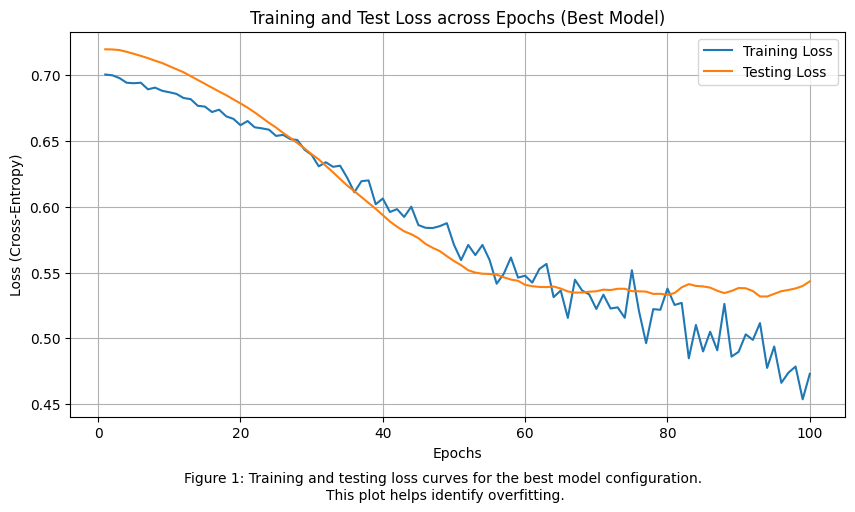

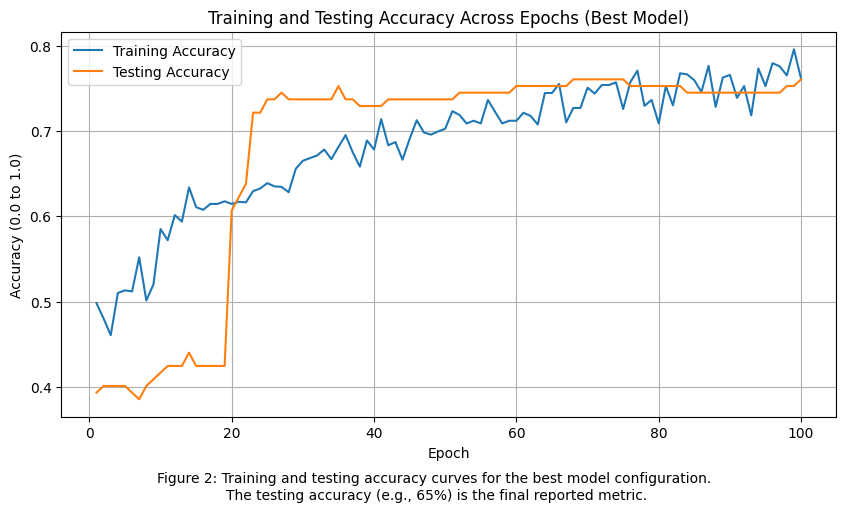

In [23]:
# matplotlib to record the hyperparemeter tuning progress

import matplotlib.pyplot as plt

epochs_range = range(1, epoch + 1)

# training and testing loss
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_loss_history, label='Training Loss')
plt.plot(epochs_range, test_loss_history, label='Testing Loss')
plt.title('Training and Test Loss across Epochs (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross-Entropy)')
plt.legend()
plt.grid(True)

plt.figtext(0.5, -0.05,
            "Figure 1: Training and testing loss curves for the best model configuration. \n"
            "This plot helps identify overfitting.",
            wrap=True, ha="center", fontsize=10)
plt.show()

# training and testing accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_acc_history, label='Training Accuracy')
plt.plot(epochs_range, test_acc_history, label='Testing Accuracy')
plt.title('Training and Testing Accuracy Across Epochs (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (0.0 to 1.0)')
plt.legend()
plt.grid(True)

plt.figtext(0.5, -0.05,
            "Figure 2: Training and testing accuracy curves for the best model configuration. \n"
            "The testing accuracy (e.g., 65%) is the final reported metric.",
            wrap=True, ha="center", fontsize=10)
plt.show()